In [2]:
import csv
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit_aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.fake_provider import GenericBackendV2
import numpy as np
from quantum_check import construct_circuit, check_consistency
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Load in data from data.csv
test_data = []

with open("data/data.csv", mode="r", newline="") as file: 
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        n = int(row[0])
        system_type = row[1]
        F1, F2, F3 = row[2], row[3], row[4]
        test_data.append((n, system_type, F1, F2, F3))

In [6]:
def experimental_quantum_test():
    exp = 0
    terms = []
    func = 0
    var = 0
    label = ''

    for data in test_data:
        exp += 1
        var = data[0]
        label = data[1]
        for i in range(len(data) - 2):
            terms.append(data[i+2])
        func = len(terms)
        
        circ = construct_circuit(terms, var, func)

        backend = GenericBackendV2(len(circ.qubits))
        circ = transpile(circ, backend)

        shots = [64, 128, 256]
        
        a_probs = []
        a_probs.append(exp)
        a_probs.append(var)
        a_probs.append(label)

        for shot in shots:
            result = backend.run(circ, shots=shot)
            probabilities = {k:v/shot for k,v in result.result().get_counts().items()}

            p0011 = probabilities.get('0011', 0)
            p1100 = probabilities.get('1100', 0)
            
            a_probs.append(probabilities.get('0000', 0))
            a_probs.append(probabilities.get('0011', 0))
            a_probs.append(probabilities.get('1100', 0))
            a_probs.append(probabilities.get('1111', 0))
        
        with open('data/experimental_probabilities.csv', mode='a', newline='') as file: #64x000,64x0011,64x1100,64x1111,128x000,128x0011,128x1100,256x1111,256x000,256x0011,256x1100,256x1111
            writer = csv.writer(file)
            writer.writerow(a_probs)
            
        print("\n");
        
        terms = []

In [12]:
terms = ["0x1x","0xx0","x01x"]
var = 4
func = 3


circ = construct_circuit(terms, var, func)

backend = GenericBackendV2(len(circ.qubits))
circ = transpile(circ, backend)

In [ ]:

# simulator = AerSimulator(method='matrix_product_state', backend = backend)

shots = [64, 128, 256]
shot = 64
job = backend.run(circ, shots=shot)
# result = simulator.run(circ, shots=shot).result()
probabilities = {k:v/shot for k,v in job.results().get_counts().items()}
plot_distribution(probabilities);

In [ ]:
experimental_quantum_test()

In [ ]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2

backend = FakeMontrealV2()

circ = construct_circuit(terms, var, func)

circ = transpile(circ, backend)

transpiled_circuit = transpile(circ, backend)
sampler = SamplerV2(backend)
job = sampler.run([transpiled_circuit])
pub_result = job.result()[0]


AttributeError: 'DataBin' object has no attribute 'meas'

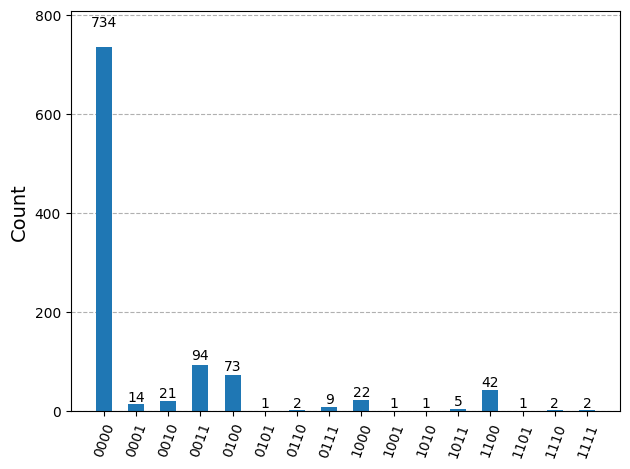

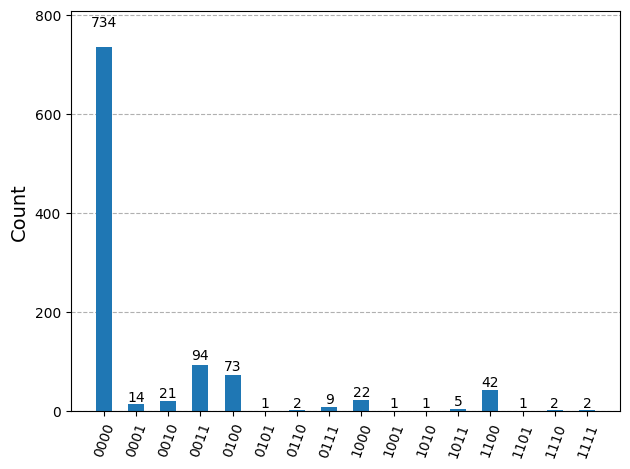

In [ ]:
counts = pub_result.data.measure_a.get_counts()
plot_histogram(counts);